# Set up

## Import

In [1]:
#import
import numpy as np
import pandas as pd

#system packages
import os
import glob
import pickle

#spatial packages
from rastertodataframe import raster_to_dataframe
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm

#processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import cluster

#modeling
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, balanced_accuracy_score

#misc
from math import floor
from itertools import product
from copy import deepcopy

In [2]:
#import custom functions
from custom_functions import *

## Download data

In [3]:
#load raws into dataframe
target_edge = 'B8A'
sim_raws = gdal_to_dataframe('../data_tests/simcoe_york/raws', nrcan_name = 'Simcoe_York_2019.tif', calculate_edge = target_edge)
lab_raws = gdal_to_dataframe('../data_tests/labrador/raws')
james_raws = gdal_to_dataframe('../data_tests/james_bay/raws', nrcan_name = 'James_Bay_Med.tif', calculate_edge = target_edge)
tor_raws = gdal_to_dataframe('../data_tests/toronto/raws', calculate_edge = target_edge)
sjames_raws = gdal_to_dataframe('../data_tests/james_south/raws', calculate_edge = target_edge)
cal_raws = gdal_to_dataframe('../data_tests/calgary/raws', calculate_edge = target_edge)
trois_raws = gdal_to_dataframe('../data_tests/trois/raws', calculate_edge = target_edge)
winn_raws = gdal_to_dataframe('../data_tests/winnipeg/raws', calculate_edge = target_edge)

getting edge
getting edge
getting edge
getting edge
getting edge
getting edge
getting edge


# EDA & Feature Selection

In [ ]:
#plot band
map_band = np.asarray(winn_raws['B12f'].values).reshape(638, 1250)
cmap = cm.get_cmap('jet', 15)    # 11 discrete colors
prediction_map = plt.imshow(map_band, cmap=cmap)

In [ ]:
#comparing example band distribution within each class across two extents
plt.scatter(lab_raws['B01'], lab_raws.y)
plt.scatter(sim_raws['B01'], sim_raws.y)

## Geocoordinates

In [4]:
#OPTIONAL: get geocoordinates
sim_raws['lat'], sim_raws['long'] = get_geocoord('../data_tests/simcoe_york/raws')
lab_raws['lat'], lab_raws['long'] = get_geocoord('../data_tests/labrador/raws')
tor_raws['lat'], tor_raws['long'] = get_geocoord('../data_tests/toronto/raws')
james_raws['lat'], james_raws['long'] = get_geocoord('../data_tests/james_bay/raws')
sjames_raws['lat'], sjames_raws['long'] = get_geocoord('../data_tests/james_south/raws')
cal_raws['lat'], cal_raws['long'] = get_geocoord('../data_tests/calgary/raws')
trois_raws['lat'], trois_raws['long'] = get_geocoord('../data_tests/trois/raws')
winn_raws['lat'], winn_raws['long'] = get_geocoord('../data_tests/winnipeg/raws')

### K-means clustering

In [ ]:
#visualize effect with test raws
test_raws = pd.concat([sim_raws, tor_raws, lab_raws, cal_raws, trois_raws, james_raws, sjames_raws])
test_raws = test_raws.drop('y', axis = 1)

cl = cluster.KMeans(n_clusters=6, random_state = 0) # create an object of the classifier
param = cl.fit(test_raws) # train it
img_cl = cl.labels_ 

#select first image for visualization
img_sim = img_cl[:2500 * 2134].reshape(2134, 2500)

In [ ]:
#visualize clustering using split images
plt.figure(figsize=[20,20])
plt.imshow(img_sim, cmap=cmap)
plt.axis('off')

### Outlier fixing

In [ ]:
#OPTIONAL: run to transform outliers on all raws

james_raws = outlier_fix(james_raws)
tor_raws = outlier_fix(tor_raws)
sim_raws = outlier_fix(sim_raws)
lab_raws = outlier_fix(lab_raws)
sjames_raws =  outlier_fix(sjames_raws)
trois_raws = outlier_fix(trois_raws)
cal_raws = outlier_fix(cal_raws)
winn_raws = outlier_fix(winn_raws)

In [ ]:
def add_fix_column(raws, target):
    raws[target] = outlier_fix(raws)[target]
    return raws

In [ ]:
#OPTIONAL: run to add single column based on an outlier fix of another
target = 'B01f'

james_raws = add_fix_column(james_raws, target)
tor_raws= add_fix_column(tor_raws, target)
sim_raws = add_fix_column(sim_raws, target)
lab_raws = add_fix_column(lab_raws, target)
sjames_raws =  add_fix_column(sjames_raws, target)
trois_raws = add_fix_column(trois_raws, target)
cal_raws = add_fix_column(cal_raws, target)
winn_raws = add_fix_column(winn_raws, target)

In [ ]:
#Double check outlier fix
plt.scatter(james_raws['B01f'], james_raws['B02f'])

### Gaussian filtering

In [ ]:
#load gaussian filtered raws
sim_gauss = filter_raws('../data_tests/simcoe_york/raws', nrcan_name = 'Simcoe_York_2019.tif')
lab_gauss = filter_raws('../data_tests/labrador/raws')
james_gauss = filter_raws('../data_tests/james_bay/raws', nrcan_name = 'James_Bay_Med.tif')
tor_gauss = filter_raws('../data_tests/toronto/raws')
sjames_gauss = filter_raws('../data_tests/james_south/raws')
cal_gauss = filter_raws('../data_tests/calgary/raws')
trois_gauss = filter_raws('../data_tests/trois/raws')
winn_gauss = filter_raws('../data_tests/winnipeg/raws')

In [ ]:
#put together raw and filtered df of each scene
#create list of input images
train_raw = [tor_raws, sim_raws, trois_raws, cal_raws]
train_gauss = [tor_gauss, sim_gauss, trois_gauss, cal_raws]

#set empty main
main_dataframe = pd.DataFrame()

for i in range(len(train_raw)):
    #drop y from gauss
    temp_gauss = train_gauss[i].drop('y', axis = 1)
    #rename gauss columns
    gauss_names = [f'{name}g' for name in temp_gauss.columns]
    temp_gauss.columns = gauss_names
    #print(temp_gauss.head(), train_raw[i].head())
    
    #reset indices
    train_raw[i].reset_index(inplace=True, drop=True)
    temp_gauss.reset_index(inplace=True, drop=True)       
    new_df = pd.concat([train_raw[i], temp_gauss], axis = 1)
    #add to main
    main_dataframe = pd.concat([main_dataframe, new_df])

print(new_df.shape, lab_raws.shape)
main_dataframe.head()

### Combine extents

In [59]:
#NOTE: skip if filtered extents have been run
#vertical concat
main_dataframe = pd.concat([sim_raws, lab_raws, tor_raws, james_raws, sjames_raws, cal_raws, trois_raws, winn_raws])
main_dataframe = main_dataframe.reset_index().drop('index', axis = 1)
#main_dataframe = replace_values(main_dataframe)                
#main_dataframe = pd.concat([tor_gauss, james_gauss, sim_gauss, lab_gauss])

In [ ]:
#OPTIONAL: run to add cluster column
cl = cluster.KMeans(n_clusters = 4)
dataframe_copy = main_dataframe.drop('y', axis = 1)
param = cl.fit(dataframe_copy.astype('double'))
img_cl = cl.labels_
    
main_dataframe['clusters'] = img_cl    

In [ ]:
#pickle cluster model
pickle.dump(param, open('models/kcluster_13.sav', 'wb'))

In [ ]:
#Visulization of band distribution for each class in the main dataframe

#number of axes = number of possible combos
fig, axes = plt.subplots(4, 3, figsize = (15, 40))

for i, ax in enumerate(axes.flat):
    
    #index of columns
    X_scatter = main_dataframe[main_dataframe.columns[:-1][i]]
    Y_scatter = main_dataframe['y']
    
    # scatter current combination
    ax.scatter(X_scatter, Y_scatter)
    ax.set_title(main_dataframe.columns[i])

# Processing Data

In [ ]:
#Getting an equal sample from each image for each class -- UNDER CONSTRUCTION, SKIP FOR NOW--
#add line in except that goes back to previous frame and samples image_threshold - count

#create list of input images
train_images = [tor_gauss, james_gauss, sjames_gauss, sim_gauss, lab_gauss, cal_gauss]

#empty subset frame
data = pd.DataFrame()

#for each image in input images
for i in range(len(train_images)):
    
    image = train_images[i]
    
    #drop 0
    image = image.loc[image.y != 0]
    
    #get class totals
    image_classes = image.value_counts('y').sort_index() 
    
    #define class threshold and threshold for class in each image
    class_threshold = 80000
    image_threshold = int(class_threshold / (len(train_images))) * 3
    
    #init empty frame to store data for each image
    subset = pd.DataFrame()
    
    #for each class
    for label in image_classes.index:
        #try to sample the image class threshold
        try:
            label_subset = image.loc[image.y == label[0]].sample(n= image_threshold, random_state=24)
        #if not possible (threshold > existing class count) then sample class count
        except:
            temp = image.loc[image.y == label[0]]
            label_subset = temp.sample(n = len(temp), random_state=24)
           
        #concat class subset into data 
        subset = pd.concat([subset, label_subset])
        
    #concat data into subset frame
    data = pd.concat([data, subset])
    
data.value_counts('y').sort_index() 

### Calculated Layers

In [60]:
#OPTIONAL: run to calculate layers
main_dataframe = add_layers(main_dataframe)
#main_dataframe = add_extra_layers(main_dataframe) #add additional layers, uncomment to add
main_dataframe = replace_values(main_dataframe)

#only keep filtered bands
#main_dataframe = main_dataframe.iloc[:, 12:]

In [ ]:
#preview calculated layers using example raw
test_plus = add_layers(trois_raws)
test_plus = replace_values(test_plus)

#preview calculated layers
map_band = np.asarray(test_plus['NDVI'].values).reshape(656, 1250)
cmap = cm.get_cmap('jet', 15)    # 11 discrete colors
prediction_map = plt.imshow(map_band, cmap=cmap)

### Subsampling

In [7]:
#check features
main_dataframe.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       'B12', 'B8A', 'edge', 'y', 'lat', 'long', 'NDVI', 'Moisture', 'NDWI',
       'NDSI'],
      dtype='object')

In [61]:
#check dataframe shape and print class value counts
print(main_dataframe.shape)
main_classes = main_dataframe.value_counts('y').sort_index() 
print(main_classes)

(13652500, 20)
y 
0      181478
1     1763151
2      309106
5     1045388
6      751140
8      785667
10     259526
11     165824
12     668623
13     631752
14     602129
15    3454935
16     670151
17     747835
18    1566302
19      49493
dtype: int64


In [9]:
#OPTIONAL: run to create a binary model by converting train and test to binary based on input class
main_dataframe = convert_binary(main_dataframe, 14)

In [62]:
#final clean
#drop 0
main_dataframe = main_dataframe.loc[main_dataframe.y != 0]

#select classes above threshold
threshold = 160000
top_classes = main_classes[main_classes > threshold].reset_index().y

#save dataframe subset of those classes
main_subset = main_dataframe.loc[main_dataframe['y'].isin(top_classes.values)]

#take smallest value rounded down to nearest 1000
smallest_class = int(floor(min(main_subset.value_counts('y').sort_index().values)/ 1000)) * 1000
#subsampling - comment out for full set
smallest_class = threshold

#take subset of each class equal to smallest class value
data = main_subset.groupby("y").sample(n=smallest_class, random_state=24)

#add on snow - uncomment if threshold > class total
snow_subset = main_dataframe.loc[main_dataframe.y == 19]
data = pd.concat([data, snow_subset])

print(data.shape)
data.value_counts('y').sort_index()

(2289493, 20)


y 
1     160000
2     160000
5     160000
6     160000
8     160000
10    160000
11    160000
12    160000
13    160000
14    160000
15    160000
16    160000
17    160000
18    160000
19     49493
dtype: int64

In [ ]:
data = main_dataframe

In [66]:
data.to_csv('../data_tests/version15.csv', index = False)

In [65]:
data['edge'] = data['edge'].astype('int')

## Train test split

In [12]:
y = data.y
X = data.drop('y', axis = 1)

#Dimensionality reduction - replace X with X_pca and run to try
pca = PCA(n_components = 1)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

[0.98673223]


In [ ]:
#OPTIONAL: run to scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

# Modelling

Random Forest, SVC, XGBoost [stretch] CNN

Iteration details:
- toronto, simcoe, sask, labrador = standard bands, no parameters, 5K each value, no scaling, in turn toronto, simcoe, sask, labrador extents only
- Base run = standard bands, no parameters, 5K each value, no scaling, sim and lab
- scaled = standard bands, no params, 5K each value, StandardScaler() -> improved SVC, sask and tor
- large set = standard bands, no parameters, 18K each value, no scaling, sim and lab
- gaussian = standard bands transformed via gaussian filter, 18K each value, no scaling, sim and lab
- demo seperated into RFC and XGB, versions correspond to below data transformation and feature selection. *RFC hypers:* unless otherwise stated used 300 trees, max depth 25 and max features 2 -> for version 11 and later it is max depth 15; Detailed map (15 color values) starts with version 10
    - version_1 = 31.41% trained on sim & lab 18K each
    - version_2 =  31.55% trained on gaussian (sigma 5) sim & lab, 18K each
    - version_3 = 33.22% trained on gaussian (sigma 1) sim & lab, 18K each
    - version_4 = 37.49% trained on gaussian (sigma 1) sim, lab, tor and james, 40K each random
    - version_5 = 34.21% trained on sim, lab, tor, james all bands, 40K each random [?? missing something can't recreate map]
    - version_6 = 33.97% (b: 34.84%) trained on raw and gaussian (sig 1) sim, lab, tor, james all bands, 40k each random
    - version_7 = 33.37% (b:33.95%) raw and median (size 10) sim, lab, tor, james all bands, 40k each random
    - version_8 = 42.11% (b:37.22%) raw with calculated layers sim, lab, tor, james all bands, 40k each
    - version_9 = 36.50 (b: 35.80%) raw with calculated layres and gauss (sig 1) sim, lab, tor, james all bands 40k each
    - version_10 = 50.87 (b: 40.89%) raw with calculated layers and column B01f with B01 where outliers < q3x2 = median sim, lab, tor, james, sjames all bands, 80k each 47K snow ; 15 max depth
    - version 11 = 46.11 (b: 39.43) raw with calculated layers and column B01f with B01 where outliers < q3x2 = median sim, lab, tor, james, sjames, calgary all bands, 60k each no snow
    - version 12 = 48.10 (b: 39.83) raw with calculated layers and cluster (n = 4) column; sim, lab, tor, james, sjames, cal, trois 100K classes with 49K snow class
    - version 13 = 48.11 (40.06) raw with calculated layers (4) and edge ('B03', sig = 1); sim, lab, tor, james, sjames, cal 150K with 49K snow class
    - version 14 = 54.39 (40.91) raw with calc layers (4), outlier B01f same as v. 10, and edge ('B8A, sig = 3); sim , lab, tor, james, sjames 100K with 47K snow
    - version 15 = 53.86 (38.94) raw with calc layers(4), geocoords, and edge ('B8A, sig = 3); sim, lab, tor, james, sjames, cal, trois, winn, 150K with 49K snow

Binary versions
- bin14 = binary class 14, trained on is or is not (1, 0) class 14 (wetland) using james, sjames raws with calculated layers (10) and 300K of is and is not; raw bands + calc layers (extra)
    - forest: using 300 trees, max depth 15 and max features 2, threshold 50
    - xgb: no hyperparam set, threshold 20

To do:
- ensure all raws are aligned to a common 60 m res grid (downsampling all but b1 and b9)
- scaling sim & lab for svc -> if goes well svc parametrization
- basic NN?

In [13]:
#set up save path for images
confusion_path = 'evaluation/'
group_folder = None

## Random Forest

0.93147


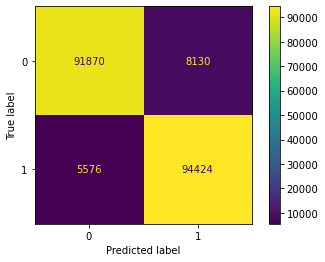

In [14]:
forest = RandomForestClassifier(random_state = 0, n_estimators = 300, max_depth = 15, max_features = 2).fit(X_train, y_train)
#get accuracy
forest_pred = forest.predict(X_test)
print(accuracy_score(y_test, forest_pred))

#plot confusion matrix
cm_forest = confusion_matrix(y_test, forest_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
cm_forest_fig.plot()

In [15]:
#make sure there's no overfit
forest_train_pred = forest.predict(X_train)
print(accuracy_score(y_train, forest_train_pred))

0.93928375


In [16]:
print_importance(forest, X_train)

          importance
lat         0.236662
long        0.179657
NDVI        0.081794
B01         0.050129
NDWI        0.048406
B04         0.048313
B02         0.045668
B12         0.043982
B11         0.035838
NDSI        0.030122
Moisture    0.027413
B09         0.026702
B05         0.025233
B07         0.023423
B08         0.021523
B03         0.021437
B8A         0.020469
B06         0.020369
edge        0.012858


In [ ]:
#OPTIONAL: save confusion matrix
cm_forest_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'forest.png'))
print(classification_report(y_test, forest_pred))

In [44]:
#OPTIONAL: save model
pickle.dump(forest, open('../models/forest_bin14_v2.sav', 'wb'))

### Demo test

In [20]:
X_demo, y_demo = process_data('../data_tests/demo_site.csv', '../data_tests/demo/raws', target_edge = 'B8A',
                 geocoords = True, target_outlier = False, gaussian = False, clustering = False, calculate_layers = True) 

getting edge


In [26]:
target_class = 14
y_demo = np.where(y_demo != target_class, 0, y_demo)
y_demo = np.where(y_demo == target_class, 1, y_demo)

In [21]:
#make sure we have the right features
X_demo.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       'B12', 'B8A', 'edge', 'lat', 'long', 'NDVI', 'Moisture', 'NDWI',
       'NDSI'],
      dtype='object')

In [ ]:
#OPTIONAL: load specific model
forest = pickle.load(open('models/forest_10.sav', 'rb'))

In [28]:
#generate predictions
demo_pred = forest.predict(X_demo)

0.6699654400205982
0.7438868571428572


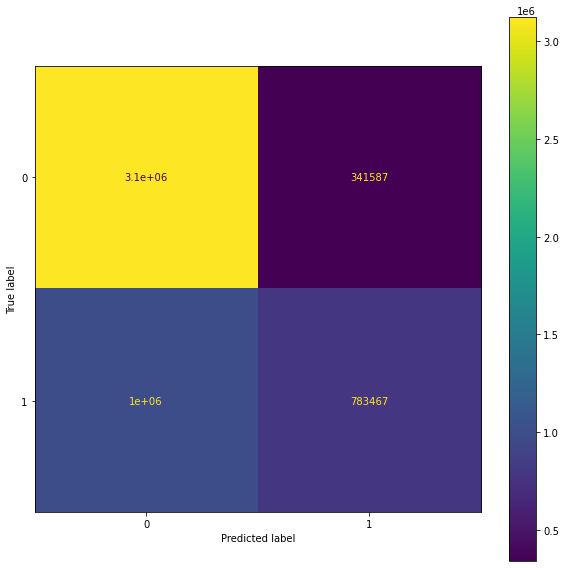

In [40]:
#accuracy
print(balanced_accuracy_score(y_demo, demo_pred))
print(accuracy_score(y_demo, demo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_demo, demo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [ ]:
print(classification_report(y_demo, demo_pred, zero_division = 0))

In [42]:
demo_pred = (forest.predict_proba(X_demo)[:,1] >= 0.6).astype(bool)

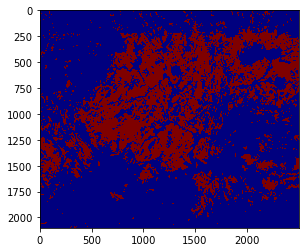

In [43]:
#plot demo prediction map
map_pred = np.asarray(demo_pred).reshape(2100, 2500)
demo_cmap = cm.get_cmap('jet', 2)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap =demo_cmap)

In [ ]:
#OPTIONAL: save matrix and map as versions
#save confusion matrix
cm_forest_fig.figure_.savefig(os.path.join(confusion_path, 'demo', 'version_15.png'))

#save prediction map
prediction_map.figure.savefig(os.path.join(confusion_path, 'demo', 'map_15.png'))

In [ ]:
#create a copy to check the distribution of specific class predicitons
check_class_pred = deepcopy(demo_pred.values)

check_class_pred = np.where(check_class_pred != 14, 0, check_class_pred)
check_class_pred = np.where(check_class_pred == 14, 1, check_class_pred)

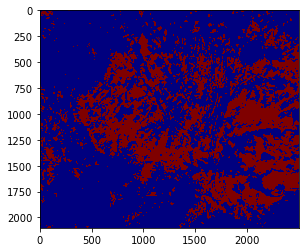

In [39]:
#plot feature or specific class
map_feat = np.asarray(y_demo).reshape(2100, 2500)
cmap = cm.get_cmap('jet', 2)    # set discrete

feature_map = plt.imshow(map_feat, cmap = cmap)

### Random extent test

In [ ]:
y_ran = trois_raws.y
X_ran = trois_raws.drop('y', axis = 1)

In [ ]:
#OPTIONAL: run to get gaussian version of toronto
gauss_test = filter_raws('../data_tests/trois/raws')
gauss_test.head()

gauss_test['y'] = gauss_test['y'].replace({0:18})

#replace X and y with gauss
#concat gauss and raw
gauss_test_reset = gauss_test.drop('y', axis = 1)
#rename gauss columns
gauss_names = [f'{name}g' for name in gauss_test_reset.columns]
gauss_test_reset.columns = gauss_names
#reset indices
trois_raws.reset_index(inplace=True, drop=True)
gauss_test_reset.reset_index(inplace=True, drop=True)    
merged_df = pd.concat([trois_raws, gauss_test_reset], axis = 1)

In [ ]:
y_ran = merged_df.y
X_ran = merged_df.drop('y', axis = 1)

In [ ]:
ran_cluster = param.predict(X_ran.astype('double'))
X_ran['clusters'] = ran_cluster

In [ ]:
#OPTIONAL: add calculated layers
X_ran = add_layers(X_ran)
X_ran = replace_values(X_ran)

In [ ]:
X_ran['B12f'] = outlier_fix(X_ran)['B12f']

In [ ]:
#optional PCA, to use replace X_tor in predict with X_tor_pca
pca = PCA(n_components = 6)
X_ran_pca = pca.fit_transform(X_ran)

#predict
ran_pred = forest.predict(X_ran)
print(balanced_accuracy_score(y_ran, ran_pred))

#display
cm_forest = confusion_matrix(y_ran, ran_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [ ]:
#display prediction map
map_pred = np.asarray(ran_pred).reshape(656, 1250)
cmap = cm.get_cmap('jet', 2)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

#save
#prediction_map.figure.savefig(os.path.join(confusion_path, 'gaussian', 'map_tor.png'))

In [ ]:
#display prediction map
map_pred = np.asarray(y_ran).reshape(656, 1250)
cmap = cm.get_cmap('jet', 2)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

## SVC

In [ ]:
#NOTE: takes a long time to run

In [ ]:
#Different SVC kernels - sig performed less then 1 percent on subsample so its removed
#linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
#rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
#sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [ ]:
#predict from X_test
#linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
#rbf_pred = rbf.predict(X_test)
#sig_pred = sig.predict(X_test)

In [ ]:
# retrieve the accuracy and print it for all 4 kernel functions
#accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
#accuracy_rbf = rbf.score(X_test, y_test)
#accuracy_sig = sig.score(X_test, y_test)

# creating a confusion matrix
#cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
#cm_rbf = confusion_matrix(y_test, rbf_pred)
#cm_sig = confusion_matrix(y_test, sig_pred)

#visual confusion matrix
#cm_lin_fig = ConfusionMatrixDisplay(confusion_matrix = cm_lin, display_labels = linear.classes_)
cm_poly_fig = ConfusionMatrixDisplay(confusion_matrix = cm_poly, display_labels = poly.classes_)
#cm_rbf_fig = ConfusionMatrixDisplay(confusion_matrix = cm_rbf, display_labels = rbf.classes_)

#print accuracy and confusion matrix
#print(accuracy_lin)
#cm_lin_fig.plot()
print(accuracy_poly)
cm_poly_fig.plot()
#print(accuracy_rbf)
#cm_rbf_fig.plot()

In [ ]:
#save confusion matrices
cm_lin_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'lin.png'), dpi = 300)
cm_poly_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'poly.png'), dpi = 300)
cm_rbf_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'rbf.png'), dpi = 300)

## XGBoost

In [ ]:
#UNDER CONSTRUCTION: Predictions are lower than they should be

In [ ]:
xg_classes

In [ ]:
xg_classes = list(range(len(y_train.unique())))

xg_y_train = y_train.replace(y_train.unique(), xg_classes)
xg_y_test = y_test.replace(y_test.unique(), xg_classes)

In [ ]:
y_train = y_train.astype('object')

In [ ]:
y_train

In [ ]:
xgb.__version__

In [46]:
X_train['edge'] = X_train['edge'].astype('int')
X_test['edge'] = X_test['edge'].astype('int')

0.935825


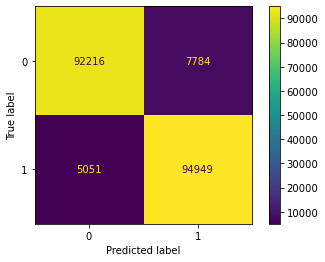

In [47]:
xg_cl = xgb.XGBClassifier().fit(X_train, y_train)

#get accuracy
accuracy_xgb = xg_cl.score(X_test, y_test)
print(accuracy_xgb)

#plot confusion matrix
xgb_pred = xg_cl.predict(X_test)
cm_xgb = confusion_matrix(y_test, xgb_pred)
cm_xgb_fig = ConfusionMatrixDisplay(cm_xgb)
cm_xgb_fig.plot()

In [ ]:
#save
cm_xgb_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'xgb.png'), dpi = 300)

In [ ]:
X_demo['edge'] = X_test['edge'].astype('int')

#generate predictions
demo_pred = xg_cl.predict_proba(X_demo)

In [48]:
demo_pred = xg_cl.predict(X_demo)

0.7258554100889677
0.7323500952380952


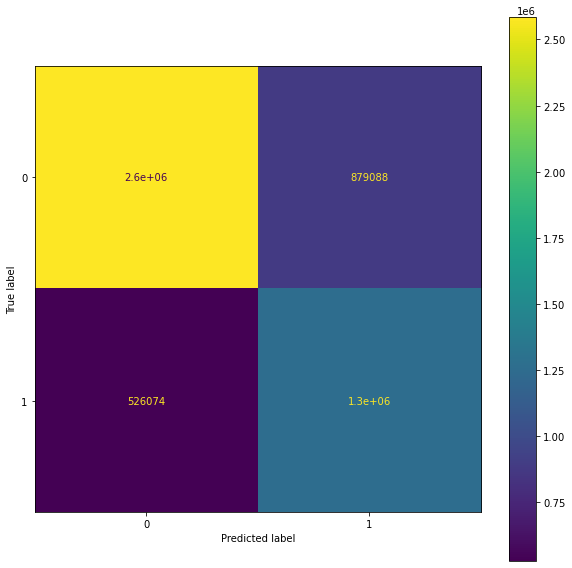

In [49]:
#accuracy
print(balanced_accuracy_score(y_demo, demo_pred))
print(accuracy_score(y_demo, demo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_demo, demo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [52]:
demo_pred = (xg_cl.predict_proba(X_demo)[:,1] >= 0.60).astype(bool)

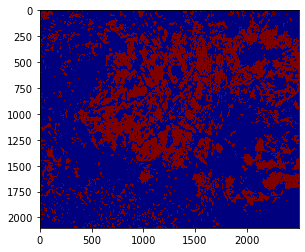

In [53]:
#plot demo prediction map
map_pred = np.asarray(demo_pred).reshape(2100, 2500)
demo_cmap = cm.get_cmap('jet', 2)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=demo_cmap)

In [ ]:
from sklearn.metrics import RocCurveDisplay

In [ ]:
RocCurveDisplay.from_predictions(y_demo, demo_pred)

In [57]:
pickle.dump(forest, open('../models/xgb_bin14_v2.sav', 'wb'))

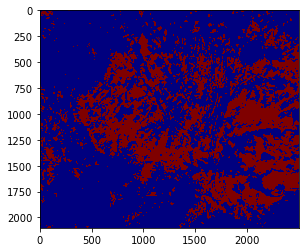

In [55]:
#plot demo prediction map
map_pred = np.asarray(y_demo).reshape(2100, 2500)
demo_cmap = cm.get_cmap('jet', 2)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=demo_cmap)

In [68]:
X_demo['edge'].astype(int)

0          0
1          0
2          0
3          0
4          0
          ..
5249995    0
5249996    0
5249997    0
5249998    0
5249999    0
Name: edge, Length: 5250000, dtype: int32

In [ ]:
#--Don't use for now, come back to it for when its time to submit--
#convert into matrices to perform gaussian then convert back into 1d array and append to dataframe
X_demo_gauss = pd.DataFrame()
for band in X_demo.columns:
    band = X_demo.columns[1]
    reconstruct = np.asarray(X_demo[band]).reshape(2500, 2100).T
    recon_gauss = gaussian_filter(reconstruct, sigma = 1)
    X_demo_gauss[band] = recon_gauss.flatten()
    
#compare demo input and gauss output
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

ax1.imshow(reconstruct)
ax2.imshow(recon_gauss)